## Report: Career Prospects In Data Related Fields


## Key Objectives: 
- Determine factors that affect job salary (regression/classification)
- Determine factors that determine job category/seniority/title/industry (classification)

- Additional: To evaluate models using a confusion matrix that is optimized towards generating false negatives (predict low, actual high) 

## Document Overview:
1. Data preparation segment
2. Analysis of factors that affect Job Salary
3. Analysis of factors determining Job Class
4. Write Up

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.ensemble import RandomForestClassifier

from pprint import pprint
import scipy.stats as stats
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style="ticks", color_codes=True)


## 1. Data preparation

<div class="alert alert-block alert-info">

### Cleaning Checklist
- Use all scraped data from two searches, reset index
- Drop reference number rows then check for duplicates
- Look into null values
- Separating jobs without salary information
- Filter out jobs relevant to data
- Clean up regions =/= north south east west central and impute as islandwide
- Inspect 'islandwide' jobs and make a decision to drop (look at impact and relevance)
- Split jobs by 'to' and create lower and upper salary range
- Check for jobs with annual salary stated and apply a divisor of 12 to both upper and lower range
- Clean up seniority (jobs with multiple seniority stated)
- Finally, drop job link and salary payment type

- Additional preparation: tokenization of Requirements writeups

</div>

In [2]:
# Loading and concatenating two datasets: One for search term: Data; one for search term: Business Intelligence
jobs = pd.read_csv('/Users/paklun/Desktop/materials-master/projects/project-4/Career_Database.csv')
bizint = pd.read_csv('/Users/paklun/Desktop/materials-master/projects/project-4/Career_Database_bizint.csv')
alljobs = pd.concat([jobs,bizint])
alljobs.reset_index(drop=True)

,Unnamed: 0,Unnamed: 0.1,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements
0,0,0,https://www.mycareersfuture.sg/job/data-engine...,South,MONEYSMART SINGAPORE PTE. LTD.,Data Engineer,Full Time,Executive,Information Technology,"$5,000to$7,000",Monthly,Roles & Responsibilities\nMission\nAs part of ...,Requirements\nCompetencies\nDegree in Computer...
1,1,1,https://www.mycareersfuture.sg/job/data-scient...,South,PORTCAST PTE. LTD.,Data Scientist,Full Time,Middle Management,Engineering,"$2,200to$6,000",Monthly,"Roles & Responsibilities\nIn this role, you wi...",Requirements\n● Comfortable working with larg...
2,2,2,https://www.mycareersfuture.sg/job/data-visual...,Central,SINGAPORE PRESS HOLDINGS LIMITED,Data Visualisation Designer,Permanent,Junior Executive,Design,"$3,500to$4,500",Monthly,Roles & Responsibilities\nDigital arm of Engli...,Requirements\nPrior experience in a data visua...
3,3,3,https://www.mycareersfuture.sg/job/data-analys...,Central,GRABTAXI HOLDINGS PTE. LTD.,Data Analyst,Full Time,Executive,Information Technology,NaN,NaN,Roles & Responsibilities\nGet to know our Team...,Requirements\nThe must haves:\nA Bachelor's/Ma...
4,4,4,https://www.mycareersfuture.sg/job/data-center...,Central,AMAZON ASIA-PACIFIC RESOURCES PRIVATE LIMITED,Data Center Engineering Project Engineer APAC,Full Time,Professional,"Design, Engineering","$9,000to$12,000",Monthly,Roles & Responsibilities\nThe Data Center Glob...,Requirements\nBasic Qualifications -\nMinimum ...
5,5,5,https://www.mycareersfuture.sg/job/lead-data-c...,Central,JOHNSON & JOHNSON PTE. LTD.,Lead Data Center Engineer,Permanent,Professional,"Engineering, Information Technology","$5,000to$10,000",Monthly,Roles & Responsibilities\nThe role of Lead Dat...,Requirements\nRequired Minimum Education: Bac...
6,6,6,https://www.mycareersfuture.sg/job/data-scient...,East,JABIL CIRCUIT (SINGAPORE) PTE. LTD.,Data Scientist - Intern (6 months),Internship,Fresh/entry level,"Information Technology, Manufacturing, Others","$800to$1,500",Monthly,Roles & Responsibilities\nEssential Duties & R...,Requirements\nEducation & Experience Requireme...
7,7,7,https://www.mycareersfuture.sg/job/data-engine...,Islandwide,ADECCO PERSONNEL PTE LTD,Data Engineer,"Contract, Full Time",Executive,Information Technology,"$5,000to$8,500",Monthly,Roles & Responsibilities\nThe Opportunity\nOur...,Requirements\nThe Talent\nMinimum of 3 - 5 yea...
8,8,8,https://www.mycareersfuture.sg/job/data-center...,Central,OPTIMUM SOLUTIONS (SINGAPORE) PTE LTD,Data Center Fiber Optics Cabling Engineer,"Contract, Full Time",Non-executive,Information Technology,"$3,000to$5,000",Monthly,Roles & Responsibilities\nCompany UEN: 1997008...,Requirements\nUrgent & Immediate Position.\nMu...
9,9,9,https://www.mycareersfuture.sg/job/data-analys...,East,EDELMAN SINGAPORE PTE. LTD.,Data Analyst,Full Time,Senior Executive,Others,NaN,NaN,Roles & Responsibilities\nDevelop predictive m...,Requirements\nQualifications\nYou should have ...


In [3]:
# Dropping reference columns
alljobs.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1,inplace=True)
alljobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4300 entries, 0 to 99
Data columns (total 11 columns):
Links              4300 non-null object
Region             4300 non-null object
Company            4283 non-null object
Title              4283 non-null object
Employment Type    4284 non-null object
Seniority          4219 non-null object
Industry           4284 non-null object
Salary             3806 non-null object
Payment            3806 non-null object
Description        4284 non-null object
Requirements       4143 non-null object
dtypes: object(11)
memory usage: 403.1+ KB


In [4]:
# Duplicate check
print('Pre-duplicate drop Shape:',alljobs.shape)
alljobs.drop_duplicates(inplace=True)
print('Post-duplicate drop Shape:',alljobs.shape)

Pre-duplicate drop Shape: (4300, 11)
Post-duplicate drop Shape: (4227, 11)


In [5]:
alljobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4227 entries, 0 to 95
Data columns (total 11 columns):
Links              4227 non-null object
Region             4227 non-null object
Company            4210 non-null object
Title              4210 non-null object
Employment Type    4211 non-null object
Seniority          4146 non-null object
Industry           4211 non-null object
Salary             3736 non-null object
Payment            3736 non-null object
Description        4211 non-null object
Requirements       4071 non-null object
dtypes: object(11)
memory usage: 396.3+ KB


<div class="alert alert-block alert-warning">
Since we might still want to retain job links with salary, lets deal with the entries without Companies and Title before proceeding
    
</div>

In [6]:
alljobs[alljobs['Company'].isnull()]

,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements
625,https://www.mycareersfuture.sg/job/pre-approva...,South,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
645,https://www.mycareersfuture.sg/job/senior-huma...,East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717,https://www.mycareersfuture.sg/job/performance...,East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
792,https://www.mycareersfuture.sg/job/technical-p...,East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
846,https://www.mycareersfuture.sg/job/purchasing-...,Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
944,https://www.mycareersfuture.sg/job/transition-...,"South, Central",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1094,https://www.mycareersfuture.sg/job/assistant-l...,South,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1452,https://www.mycareersfuture.sg/job/senior-data...,"South, East, Central",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1684,https://www.mycareersfuture.sg/job/digital-ele...,North,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1811,https://www.mycareersfuture.sg/job/accounts-ex...,East,NaN,NaN,"Permanent, Full Time",Executive,Accounting / Auditing / Taxation,"$2,000to$3,200",Monthly,Roles & Responsibilities\nThe Accounts Executi...,Requirements\n~ Assign account codes to all tr...


In [7]:
alljobs[alljobs['Seniority'].isnull()]

,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements
39,https://www.mycareersfuture.sg/job/assistant-d...,Permanent,MINISTRY OF DEFENCE,Assistant Director (Integrated Feedback System),Permanent,NaN,"Human Resources , Public / Civil Service",NaN,NaN,"Roles & Responsibilities\nYou lead, develop an...",NaN
137,https://www.mycareersfuture.sg/job/manager-sen...,Full Time,SMART NATION AND DIGITAL GOVERNMENT OFFICE,"Manager / Senior Manager, Finance and Resourci...",Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nExcited to make a di...,NaN
141,https://www.mycareersfuture.sg/job/senior-mana...,Full Time,SMART NATION AND DIGITAL GOVERNMENT OFFICE,"Senior Manager / Manager (ICT), WOG ICT Infra ...",Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nAre you a change mak...,NaN
166,https://www.mycareersfuture.sg/job/senior-mana...,Full Time,SKILLSFUTURE SINGAPORE AGENCY,"Senior Manager / Manager, Funding Policy (Reso...",Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\n Responsibilities \...,NaN
422,https://www.mycareersfuture.sg/job/manager-sen...,Full Time,MINISTRY OF MANPOWER,"Manager / Senior Manager, Compliance Strategy ...",Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nThe job holder is re...,NaN
484,https://www.mycareersfuture.sg/job/procurement...,Full Time,MINISTRY OF HOME AFFAIRS,Procurement Executive,Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nThe Ministry of Home...,NaN
613,https://www.mycareersfuture.sg/job/assistant-m...,Full Time,MINISTRY OF SOCIAL AND FAMILY DEVELOPMENT,"Assistant Manager (Systems, Exclusion and Visi...",Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nThe Gambling Safegua...,NaN
619,https://www.mycareersfuture.sg/job/assistant-m...,Full Time,MINISTRY OF SOCIAL AND FAMILY DEVELOPMENT,Assistant Manager / Manager (Child and Family ...,Full Time,NaN,Public / Civil Service,NaN,NaN,Roles & Responsibilities\nThe ComCare and Soci...,NaN
625,https://www.mycareersfuture.sg/job/pre-approva...,South,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
645,https://www.mycareersfuture.sg/job/senior-huma...,East,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-warning">
Seems like jobs with Seniority field null are govt jobs and most are not data related & also problematic in the Salary field (null values). We will drop them
    
</div>

In [8]:
# Dropping rows with null values in these 3 columns
alljobs.dropna(subset=['Company','Title','Seniority'],inplace=True)
alljobs.shape

(4145, 11)

In [9]:
alljobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4145 entries, 0 to 95
Data columns (total 11 columns):
Links              4145 non-null object
Region             4145 non-null object
Company            4145 non-null object
Title              4145 non-null object
Employment Type    4145 non-null object
Seniority          4145 non-null object
Industry           4145 non-null object
Salary             3725 non-null object
Payment            3725 non-null object
Description        4145 non-null object
Requirements       4070 non-null object
dtypes: object(11)
memory usage: 388.6+ KB


<div class="alert alert-block alert-warning">
    Let's split the dataset into two, depending if salary is specified.
    </div>

In [10]:
nopay = alljobs[alljobs['Salary'].isnull()].copy().reset_index(drop=True)
nopay.shape

(420, 11)

In [11]:
paidjobs = alljobs[alljobs['Salary'].notnull()].copy().reset_index(drop=True)
print(paidjobs.shape)
paidjobs.tail()

(3725, 11)


,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements
3720,https://www.mycareersfuture.sg/job/bi-sales-ma...,Central,XPLORE INFOCOMZ SOLUTION (PTE. LTD.),BI Sales Manager (ASEAN),Permanent,Professional,Information Technology,"$6,000to$8,000",Monthly,Roles & Responsibilities\nIt is a Account Mana...,Requirements\n8+ years overall sales experienc...
3721,https://www.mycareersfuture.sg/job/software-en...,South,ENHANZCOM PTE. LTD.,Software Engineer,Full Time,Executive,Information Technology,"$2,200to$2,500",Monthly,Roles & Responsibilities\nMaintain and impleme...,Requirements\nDiploma or Degree in IT or Comp...
3722,https://www.mycareersfuture.sg/job/senior-sale...,Central,MIDEA ELECTRIC TRADING (SINGAPORE) CO. PTE. LTD.,Senior Sales & Marketing Manager,Full Time,"Manager, Executive, Senior Executive","Marketing / Public Relations , Sales / Retail","$5,000to$6,500",Monthly,Roles & Responsibilities\nManager of Sales & M...,Requirements\nExperience & Background\n3+ year...
3723,https://www.mycareersfuture.sg/job/business-in...,South,ADECCO PERSONNEL PTE LTD,Business Intelligence Software Engineer,"Contract, Full Time",Executive,Information Technology,"$5,000to$7,500",Monthly,Roles & Responsibilities\nMain responsibilitie...,Requirements\nThis position requires 5+ years ...
3724,https://www.mycareersfuture.sg/job/business-in...,Central,HAYS SPECIALIST RECRUITMENT PTE. LTD.,Business Intelligence Analyst,"Permanent, Contract, Full Time",Junior Executive,Information Technology,"$4,000to$5,000",Monthly,Roles & Responsibilities\nThis consultancy com...,Requirements\nExcellent communication and stak...


In [12]:
paidjobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3725 entries, 0 to 3724
Data columns (total 11 columns):
Links              3725 non-null object
Region             3725 non-null object
Company            3725 non-null object
Title              3725 non-null object
Employment Type    3725 non-null object
Seniority          3725 non-null object
Industry           3725 non-null object
Salary             3725 non-null object
Payment            3725 non-null object
Description        3725 non-null object
Requirements       3673 non-null object
dtypes: object(11)
memory usage: 320.2+ KB


<div class="alert alert-block alert-warning">
   Filtering data relevant jobs & Setting unclean region data to 'islandwide'
    </div>

In [13]:
# Filtering relevant jobs by Title inclusions
datapaidjobs = paidjobs[paidjobs.Title.str.contains('data|analyst|intelligence|scientist|engineer|tech|python', case=False,regex=True)].copy()
datapaidjobs.Region.value_counts()

Central                        518
East                           227
South                          214
Islandwide                     168
West                           152
North                           76
Full Time                       23
East, Central                    8
North, Central                   8
South, Central                   7
Contract                         7
South, East, Central             6
Permanent                        3
North, West                      2
North, South, Central            2
North, East                      1
South, East                      1
Permanent ...                    1
North, South, East, Central      1
Name: Region, dtype: int64

In [14]:
datapaidjobs.Region[(datapaidjobs.Region != 'Central') & (datapaidjobs.Region != 'South') & (datapaidjobs.Region != 'North') & (datapaidjobs.Region != 'West') & (datapaidjobs.Region != 'East') & (datapaidjobs.Region != 'Islandwide')] = 'Islandwide'
datapaidjobs.Region.value_counts()

Central       518
Islandwide    238
East          227
South         214
West          152
North          76
Name: Region, dtype: int64

In [15]:
datapaidjobs.reset_index(inplace=True, drop=True)
print(datapaidjobs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 11 columns):
Links              1425 non-null object
Region             1425 non-null object
Company            1425 non-null object
Title              1425 non-null object
Employment Type    1425 non-null object
Seniority          1425 non-null object
Industry           1425 non-null object
Salary             1425 non-null object
Payment            1425 non-null object
Description        1425 non-null object
Requirements       1392 non-null object
dtypes: object(11)
memory usage: 122.5+ KB
None


<div class="alert alert-block alert-warning">
    Splitting the salary brackets & dividing salary by 12 for annual types
    </div>

In [16]:
# Splitting the salary string
datapaidjobs['Salary_Min'] = datapaidjobs.Salary.str.split(pat='to').str[0]
datapaidjobs['Salary_Max'] = datapaidjobs.Salary.str.split(pat='to').str[1]
datapaidjobs

,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements,Salary_Min,Salary_Max
0,https://www.mycareersfuture.sg/job/data-engine...,South,MONEYSMART SINGAPORE PTE. LTD.,Data Engineer,Full Time,Executive,Information Technology,"$5,000to$7,000",Monthly,Roles & Responsibilities\nMission\nAs part of ...,Requirements\nCompetencies\nDegree in Computer...,"$5,000","$7,000"
1,https://www.mycareersfuture.sg/job/data-scient...,South,PORTCAST PTE. LTD.,Data Scientist,Full Time,Middle Management,Engineering,"$2,200to$6,000",Monthly,"Roles & Responsibilities\nIn this role, you wi...",Requirements\n● Comfortable working with larg...,"$2,200","$6,000"
2,https://www.mycareersfuture.sg/job/data-visual...,Central,SINGAPORE PRESS HOLDINGS LIMITED,Data Visualisation Designer,Permanent,Junior Executive,Design,"$3,500to$4,500",Monthly,Roles & Responsibilities\nDigital arm of Engli...,Requirements\nPrior experience in a data visua...,"$3,500","$4,500"
3,https://www.mycareersfuture.sg/job/data-center...,Central,AMAZON ASIA-PACIFIC RESOURCES PRIVATE LIMITED,Data Center Engineering Project Engineer APAC,Full Time,Professional,"Design, Engineering","$9,000to$12,000",Monthly,Roles & Responsibilities\nThe Data Center Glob...,Requirements\nBasic Qualifications -\nMinimum ...,"$9,000","$12,000"
4,https://www.mycareersfuture.sg/job/lead-data-c...,Central,JOHNSON & JOHNSON PTE. LTD.,Lead Data Center Engineer,Permanent,Professional,"Engineering, Information Technology","$5,000to$10,000",Monthly,Roles & Responsibilities\nThe role of Lead Dat...,Requirements\nRequired Minimum Education: Bac...,"$5,000","$10,000"
5,https://www.mycareersfuture.sg/job/data-scient...,East,JABIL CIRCUIT (SINGAPORE) PTE. LTD.,Data Scientist - Intern (6 months),Internship,Fresh/entry level,"Information Technology, Manufacturing, Others","$800to$1,500",Monthly,Roles & Responsibilities\nEssential Duties & R...,Requirements\nEducation & Experience Requireme...,$800,"$1,500"
6,https://www.mycareersfuture.sg/job/data-engine...,Islandwide,ADECCO PERSONNEL PTE LTD,Data Engineer,"Contract, Full Time",Executive,Information Technology,"$5,000to$8,500",Monthly,Roles & Responsibilities\nThe Opportunity\nOur...,Requirements\nThe Talent\nMinimum of 3 - 5 yea...,"$5,000","$8,500"
7,https://www.mycareersfuture.sg/job/data-center...,Central,OPTIMUM SOLUTIONS (SINGAPORE) PTE LTD,Data Center Fiber Optics Cabling Engineer,"Contract, Full Time",Non-executive,Information Technology,"$3,000to$5,000",Monthly,Roles & Responsibilities\nCompany UEN: 1997008...,Requirements\nUrgent & Immediate Position.\nMu...,"$3,000","$5,000"
8,https://www.mycareersfuture.sg/job/data-analys...,Central,ECQUARIA TECHNOLOGIES PTE LTD,Data Analyst,Permanent,"Middle Management, Executive",Information Technology,"$4,000to$5,000",Monthly,"Roles & Responsibilities\nIdentify, analyze, a...","Requirements\nDegree in Computer Science, Info...","$4,000","$5,000"
9,https://www.mycareersfuture.sg/job/senior-data...,Central,AMAZON ASIA-PACIFIC RESOURCES PRIVATE LIMITED,Senior Data Center Infrastructure Availability...,Full Time,Professional,"Building and Construction, Design, Engineering...","$14,000to$17,000",Monthly,Roles & Responsibilities\nAmazon Web Service (...,Requirements\nBASIC QUALIFICATIONS\nBachelor’s...,"$14,000","$17,000"


In [17]:
# Converting the currency type to numeric format
datapaidjobs['Salary_Min'] = datapaidjobs['Salary_Min'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.int64)
datapaidjobs['Salary_Max'] = datapaidjobs['Salary_Max'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.int64)
datapaidjobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 13 columns):
Links              1425 non-null object
Region             1425 non-null object
Company            1425 non-null object
Title              1425 non-null object
Employment Type    1425 non-null object
Seniority          1425 non-null object
Industry           1425 non-null object
Salary             1425 non-null object
Payment            1425 non-null object
Description        1425 non-null object
Requirements       1392 non-null object
Salary_Min         1425 non-null int64
Salary_Max         1425 non-null int64
dtypes: int64(2), object(11)
memory usage: 144.8+ KB


In [18]:
# Applying annual->monthly divisor via masking
mask = datapaidjobs[(datapaidjobs.Payment == 'Annually')]
datapaidjobs.loc[(datapaidjobs.Payment == 'Annually'),'Salary_Min'] = round(mask['Salary_Min']/12,2)
datapaidjobs.loc[(datapaidjobs.Payment == 'Annually'),'Salary_Max'] = round(mask['Salary_Max']/12,2)


datapaidjobs[(datapaidjobs.Payment == 'Annually')]

,Links,Region,Company,Title,Employment Type,Seniority,Industry,Salary,Payment,Description,Requirements,Salary_Min,Salary_Max
89,https://www.mycareersfuture.sg/job/reporting-s...,Central,DHL EXPRESS (SINGAPORE) PTE. LTD.,Reporting Senior Analyst,Permanent,Senior Executive,Logistics / Supply Chain,"$65,000to$90,000",Annually,Roles & Responsibilities\nRole Purpose\nBe the...,Requirements\nRequirements\nUniversity degree ...,5416.67,7500.00
126,https://www.mycareersfuture.sg/job/data-center...,Central,UBS AG,Data Center Service Manager,Full Time,Senior Executive,Banking and Finance,"$160,000to$240,000",Annually,Roles & Responsibilities\nAre you passionate a...,Requirements\n- At least 5 years' experience i...,13333.33,20000.00
136,https://www.mycareersfuture.sg/job/data-scient...,Central,SPOTIFY SINGAPORE PTE. LTD.,Data Scientist,Permanent,Executive,Others,"$90,000to$110,000",Annually,Roles & Responsibilities\nWe seek an outstandi...,Requirements\nWho you are\nDegree in Computer ...,7500.00,9166.67
142,https://www.mycareersfuture.sg/job/engineer-bu...,Islandwide,"TURNER BROADCASTING SALES SOUTHEAST ASIA, INC","Engineer, Business Intelligence",Permanent,Executive,Information Technology,"$68,040to$83,160",Annually,Roles & Responsibilities\nThe Business Intelli...,Requirements\nEssential\n1. 4+ years solid exp...,5670.00,6930.00
266,https://www.mycareersfuture.sg/job/analyst-job...,Central,MUFG FUND SERVICES (SINGAPORE) PTE. LTD.,"Analyst, Job",Permanent,Junior Executive,Banking and Finance,"$50,000to$65,000",Annually,Roles & Responsibilities\nEnsure timely and ac...,"Requirements\nHonours degree in Finance, Busin...",4166.67,5416.67
348,https://www.mycareersfuture.sg/job/risk-analys...,Central,MAKO APAC PTE. LTD.,Risk Analyst,"Permanent, Full Time",Executive,Banking and Finance,"$80,000to$90,000",Annually,Roles & Responsibilities\nPosition Details\nTh...,Requirements\nMain Responsibilities\nThe succe...,6666.67,7500.00
368,https://www.mycareersfuture.sg/job/data-scient...,South,CISCO SYSTEMS (USA) PTE. LTD.,Data Scientist,Full Time,"Fresh/entry level, Junior Executive",Banking and Finance,"$57,000to$80,000",Annually,Roles & Responsibilities\n What You'll Do\nAs...,Requirements\nWho You Are\n• Thrive in a multi...,4750.00,6666.67
448,https://www.mycareersfuture.sg/job/lead-data-s...,South,BIGTAPP PTE. LTD.,Lead Data Scientist,Full Time,Senior Executive,"Consulting , Information Technology","$80,000to$100,000",Annually,Roles & Responsibilities\nThe position involve...,Requirements\nMinimum of 6 to 8 years of Data ...,6666.67,8333.33
451,https://www.mycareersfuture.sg/job/data-soluti...,Central,MICROSOFT OPERATIONS PTE LTD,Data Solution Architect,Full Time,Non-executive,Information Technology,"$164,500to$246,500",Annually,Roles & Responsibilities\nMicrosoft envisions ...,Requirements\nExperiences Required:\n* Technic...,13708.33,20541.67
464,https://www.mycareersfuture.sg/job/business-in...,East,INFOCEPTS PTE. LTD.,Business Intelligence - Senior Program Manager,Full Time,Senior Management,"Consulting , Information Technology","$118,800to$145,200",Annually,Roles & Responsibilities\nPosition ...,Requirements\nQualifications & Skills:-\nShoul...,9900.00,12100.00


In [19]:
datapaidjobs['Salary_Avg'] = (datapaidjobs['Salary_Max']+datapaidjobs['Salary_Min'])/2
datapaidjobs.describe()

,Salary_Min,Salary_Max,Salary_Avg
count,1425.000000,1425.000000,1425.000000
mean,5068.922568,7962.427607,6515.675088
std,3276.944289,5336.939439,4158.725298
min,20.000000,800.000000,650.000000
25%,3400.000000,5000.000000,4300.000000
50%,4800.000000,7000.000000,6000.000000
75%,6000.000000,9500.000000,8000.000000
max,60000.000000,85000.000000,70000.000000


In [20]:
# Dropping useless columns
datapaidjobs.drop(['Links','Salary','Payment'],inplace=True, axis=1)
datapaidjobs.shape

(1425, 11)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


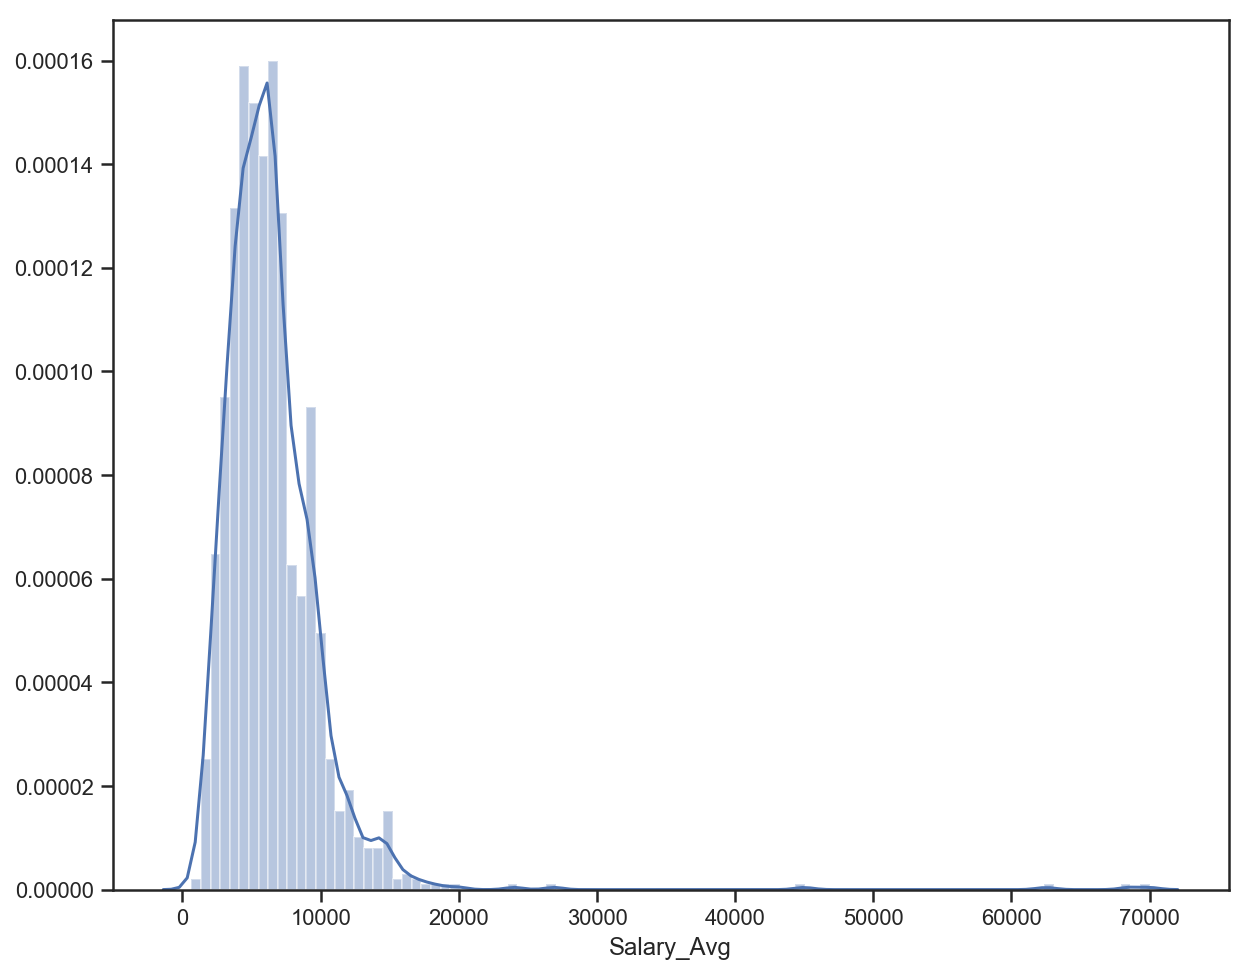

In [21]:
plt.figure(figsize=(10,8))
sns.distplot(datapaidjobs.Salary_Avg,bins=100);

<div class="alert alert-block alert-warning">
Seems like the avg monthly salaries are distributed normally below $20000, with a handful of outliers between 20k - 70k skewing the data. Let's investigate the extreme outliers.
</div>

In [22]:
datapaidjobs[(datapaidjobs.Salary_Avg >= 30000)]

,Region,Company,Title,Employment Type,Seniority,Industry,Description,Requirements,Salary_Min,Salary_Max,Salary_Avg
479,North,NCS PTE. LTD.,Lead / Senior Database Administrator,Permanent,Professional,Information Technology,Roles & Responsibilities\nPosition Summary\nSe...,Requirements\nMinimum 3 years of experience in...,5000.0,85000.0,45000.0
616,Central,COMPANY UNDISCLOSED,Research Engineer,Full Time,Fresh/entry level,Information Technology,Roles & Responsibilities\nCOMPANY DESCRIPTION\...,Requirements\nRequired Skills:\nBS/MS in Compu...,60000.0,80000.0,70000.0
1127,Central,DTCC DATA REPOSITORY (SINGAPORE) PTE. LTD.,Senior Business Systems Analyst,Full Time,Senior Executive,Information Technology,Roles & Responsibilities\nBusiness Unit Descri...,Requirements\nQualifications\nMinimum of 8 yea...,50000.0,75000.0,62500.0
1335,East,VISA WORLDWIDE PTE. LIMITED,"New Grad, Senior Software Engineer (Master's D...",Full Time,Fresh/entry level,Information Technology,"Roles & Responsibilities\nCommon Purpose, Unco...",Requirements\nSo what are we looking for in a ...,57000.0,80000.0,68500.0


<div class="alert alert-block alert-warning">
    Seems like the outliers are likely erroneous entries, so we shall drop
</div>

In [23]:
# Subsetting jobs
datapaidjobs2 = (datapaidjobs[(datapaidjobs.Salary_Avg <= 30000)]).copy().reset_index()
datapaidjobs2.shape

(1421, 12)

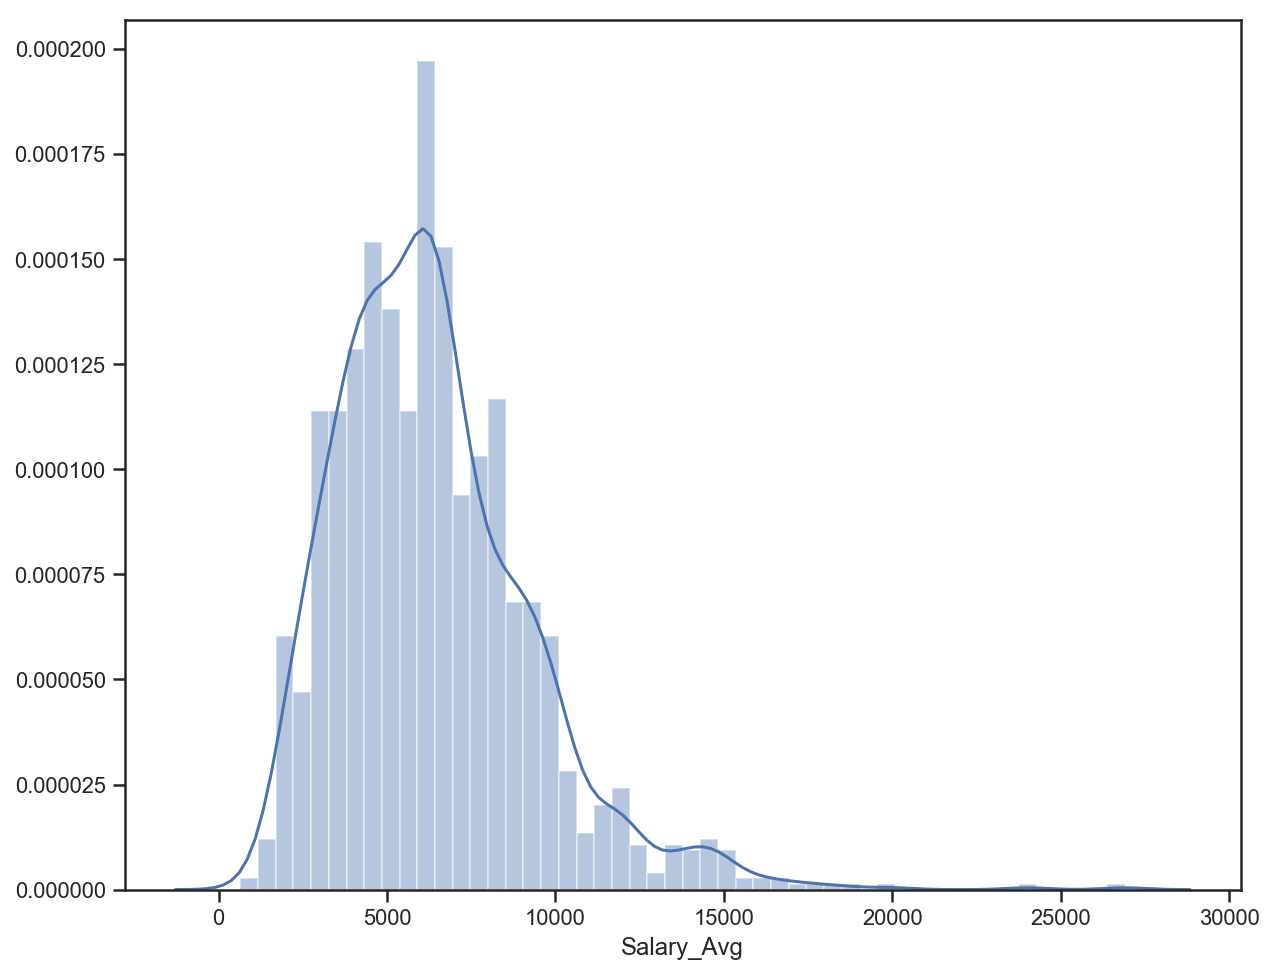

In [24]:
plt.figure(figsize=(10,8))
sns.distplot(datapaidjobs2.Salary_Avg,bins=50);

<div class="alert alert-block alert-warning">
Then, we will clean up seniority & employment type using a self defined function to manually simulate getting dummy variables from multi-category inputs
</div>

In [25]:
#write a function that will create dummy variables when the field has multiple options/categories

def create_dummy(colname,df):
    
    all_cat = set()
    #this is a set containing all the possible categories and we will feature engineer the corresponding number of columns

    cat_list = df[colname].str.replace(' , ',', ').str.split(', ')
#     print(len(cat_list))
    
    for category in cat_list:
        #create a column
        for i in category:
            all_cat.add(i)
        
    
    #create a list of dictionaries, to be converted to dataframe later on
    cat_dummies = []
    
    #for each category that is listed for that row
    for category in cat_list:
        row = {}
        for cat in all_cat:#for all possible categories
            if cat in category:
                row[cat] = 1 #this job listing has listed this employment type
            else:
                row[cat] = 0 #this job listing did not list this employment type
                    
        cat_dummies.append(row)        
    
    dummy_df = pd.DataFrame(cat_dummies)#convert list of dictionaries to dataframe
    
    return dummy_df

In [26]:
# creating a dummy variable df for seniority
senioritydummy = create_dummy('Seniority',datapaidjobs2)
senioritydummy.shape

(1421, 9)

In [27]:
# creating a dummy variable df for employment types
employmentdummy = create_dummy('Employment Type',datapaidjobs2)
employmentdummy.shape

(1421, 8)

In [28]:
# merging all datasets together and then dropping
datapaidjobsdummied = pd.concat([datapaidjobs2,employmentdummy,senioritydummy],axis=1)
datapaidjobsdummied.drop(['index','Permanent','Fresh/entry level'],inplace=True,axis=1)
datapaidjobsdummied.head()

,Region,Company,Title,Employment Type,Seniority,Industry,Description,Requirements,Salary_Min,Salary_Max,...,Part Time,Temporary,Executive,Junior Executive,Manager,Middle Management,Non-executive,Professional,Senior Executive,Senior Management
0,South,MONEYSMART SINGAPORE PTE. LTD.,Data Engineer,Full Time,Executive,Information Technology,Roles & Responsibilities\nMission\nAs part of ...,Requirements\nCompetencies\nDegree in Computer...,5000.0,7000.0,...,0,0,1,0,0,0,0,0,0,0
1,South,PORTCAST PTE. LTD.,Data Scientist,Full Time,Middle Management,Engineering,"Roles & Responsibilities\nIn this role, you wi...",Requirements\n● Comfortable working with larg...,2200.0,6000.0,...,0,0,0,0,0,1,0,0,0,0
2,Central,SINGAPORE PRESS HOLDINGS LIMITED,Data Visualisation Designer,Permanent,Junior Executive,Design,Roles & Responsibilities\nDigital arm of Engli...,Requirements\nPrior experience in a data visua...,3500.0,4500.0,...,0,0,0,1,0,0,0,0,0,0
3,Central,AMAZON ASIA-PACIFIC RESOURCES PRIVATE LIMITED,Data Center Engineering Project Engineer APAC,Full Time,Professional,"Design, Engineering",Roles & Responsibilities\nThe Data Center Glob...,Requirements\nBasic Qualifications -\nMinimum ...,9000.0,12000.0,...,0,0,0,0,0,0,0,1,0,0
4,Central,JOHNSON & JOHNSON PTE. LTD.,Lead Data Center Engineer,Permanent,Professional,"Engineering, Information Technology",Roles & Responsibilities\nThe role of Lead Dat...,Requirements\nRequired Minimum Education: Bac...,5000.0,10000.0,...,0,0,0,0,0,0,0,1,0,0


<div class="alert alert-block alert-warning">
We now have one-hot encoded a Permanent, Fresh/Entry job as the default. Next will be to prepare the textual description columns for processing.
</div>

In [29]:
# Cleaning some scrap noise and segment headers
datapaidjobsdummied['Description'] = datapaidjobsdummied['Description'].str.replace('\n',' ').str.replace('Roles & Responsibilities','')
datapaidjobsdummied['Requirements'] = datapaidjobsdummied['Requirements'].str.replace('\n',' ').str.replace('Requirements','')

In [30]:
custom_stop_words = list(ENGLISH_STOP_WORDS)

# Adding own custom stopwords
custom_stop_words.append('email')
custom_stop_words.append('cv')
custom_stop_words.append('is')

len(custom_stop_words)

321

In [31]:
# Null value in requirements throw error when doing countvectorizing, so imputing a stop-word so that it doesn't affect the data
datapaidjobsdummied.Requirements.fillna('is',inplace=True)
datapaidjobsdummied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 26 columns):
Region               1421 non-null object
Company              1421 non-null object
Title                1421 non-null object
Employment Type      1421 non-null object
Seniority            1421 non-null object
Industry             1421 non-null object
Description          1421 non-null object
Requirements         1421 non-null object
Salary_Min           1421 non-null float64
Salary_Max           1421 non-null float64
Salary_Avg           1421 non-null float64
Contract             1421 non-null int64
Flexi work           1421 non-null int64
Freelance            1421 non-null int64
Full Time            1421 non-null int64
Internship           1421 non-null int64
Part Time            1421 non-null int64
Temporary            1421 non-null int64
Executive            1421 non-null int64
Junior Executive     1421 non-null int64
Manager              1421 non-null int64
Middle Management 

In [32]:
cvec = CountVectorizer(stop_words=custom_stop_words, ngram_range=(1,3),max_features= 5000)
X = cvec.fit_transform(datapaidjobsdummied['Requirements'])
cvec.vocabulary_

{'competencies': 801,
 'degree': 1121,
 'computer': 836,
 'science': 3886,
 'years': 4959,
 'relevant': 3705,
 'working': 4890,
 'experience': 1637,
 'data': 1020,
 'warehouse': 4802,
 'modelling': 2890,
 'sql': 4211,
 'experienced': 1787,
 'etl': 1575,
 'elt': 1427,
 'scripting': 3922,
 'applications': 303,
 'preferably': 3339,
 'using': 4703,
 'python': 3542,
 'knowledge': 2483,
 'stream': 4286,
 'processing': 3419,
 'messaging': 2817,
 'clustering': 691,
 'operating': 3071,
 'databases': 1090,
 'background': 430,
 'running': 3848,
 'production': 3428,
 'bonus': 496,
 'points': 3281,
 'coding': 705,
 'ruby': 3845,
 'analysis': 228,
 'projects': 3493,
 'business': 531,
 'stakeholders': 4236,
 'cultural': 988,
 'values': 4727,
 'build': 518,
 'positive': 3295,
 'team': 4440,
 'family': 1843,
 'spirit': 4201,
 'stay': 4273,
 'productive': 3430,
 'learning': 2579,
 'growth': 2077,
 'engage': 1457,
 'commit': 747,
 'degree computer': 1126,
 'computer science': 841,
 'years relevant': 4985

## 2. Modeling for Salary

<div class="alert alert-block alert-info">

### Modeling approach
- Try (minus Descriptions and Requirements)
- Test logistic regressions with dummified fields and Salary 
- Test with Random Forest Classifier


</div>

### Model 1: LR 

In [37]:
datapaidjobsdummied.Salary_Avg.describe()

count     1421.000000
mean      6360.898663
std       2919.872345
min        650.000000
25%       4250.000000
50%       6000.000000
75%       7750.000000
max      26900.000000
Name: Salary_Avg, dtype: float64

In [39]:
datapaidjobsdummied['Salary_Label'] = datapaidjobsdummied['Salary_Avg'].apply(lambda x: 0 if x < 6000 else 1)

In [ ]:
modeldf = datapaidjobsdummied.drop([''])


In [33]:
datapaidjobsdummied.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 26 columns):
Region               1421 non-null object
Company              1421 non-null object
Title                1421 non-null object
Employment Type      1421 non-null object
Seniority            1421 non-null object
Industry             1421 non-null object
Description          1421 non-null object
Requirements         1421 non-null object
Salary_Min           1421 non-null float64
Salary_Max           1421 non-null float64
Salary_Avg           1421 non-null float64
Contract             1421 non-null int64
Flexi work           1421 non-null int64
Freelance            1421 non-null int64
Full Time            1421 non-null int64
Internship           1421 non-null int64
Part Time            1421 non-null int64
Temporary            1421 non-null int64
Executive            1421 non-null int64
Junior Executive     1421 non-null int64
Manager              1421 non-null int64
Middle Management 